In [1]:
%load_ext autoreload
%autoreload 2

import cvxpy as cp
import numpy as np
import numpy.linalg as la
from argparse import Namespace
import matplotlib.pyplot as plt
import time

In [2]:
K = 50
parameters = dict(K=K, ri=np.zeros(3), vi=np.zeros(3), ai=np.zeros(3),
                  rf=np.array([.4,.0,0]), vf=np.zeros(3), af=np.zeros(3),
                  wp=np.array([.2,.1,0]), wp_idx=int(K/3),
                  gravity=np.array([0.,0.,-9.81]),
                  v_fast=.5, v_slow=.25, a_min=5., a_max=12.0, 
                  theta_max=np.radians(20.0),
                  j_max=40, max_iter=30,
                  weight_ri=1e3, weight_rf=1e4, weight_wp=1e4,
                  weight_obs=1e2, weight_trust=1e-2, n_obs=1)

""" Initialize parameters """
P = Namespace(**parameters)

ri = cp.Parameter(3)
vi = cp.Parameter(3)
ai = cp.Parameter(3)
rf = cp.Parameter(3)
vf = cp.Parameter(3)
af = cp.Parameter(3)
wp = cp.Parameter(3)

w_rf = cp.Parameter()
w_wp = cp.Parameter()
w_trust = cp.Parameter()
# w_obs = cp.Parameter()
# w_ri = cp.Parameter()

ri.value = P.ri
vi.value = P.vi
ai.value = P.ai
rf.value = P.rf
vf.value = P.vf
af.value = P.af
wp.value = P.wp

w_rf.value = P.weight_rf
w_wp.value = P.weight_wp
w_trust.value = P.weight_trust
# w_obs.value = P.weight_obs
# w_ri.value = P.weight_ri

""" Initialize variables """
r = cp.Variable((P.K, 3))
v = cp.Variable((P.K, 3))
a = cp.Variable((P.K, 3))
dtau = cp.Variable()

r0 = cp.Parameter((P.K, 3))
v0 = cp.Parameter((P.K, 3))
a0 = cp.Parameter((P.K, 3))
tau = cp.Parameter()
stc = cp.Parameter(P.K)

s = cp.Variable(P.K, nonneg=True)
eta = cp.Variable((P.K, P.n_obs), nonneg=True)
delta = cp.Variable((P.K, 2), nonneg=True)
trust = cp.Variable(nonneg=True)

rf_relax = cp.Variable(3)
ri_relax = cp.Variable(3)
wp_relax = cp.Variable(3)

s_ri = cp.Variable()
s_rf = cp.Variable()
s_wp = cp.Variable()

sigma = cp.Variable(nonneg=True)
# helper variables to maintain disciplined parametric programming
raccel = cp.Variable((P.K-1, 3))
Dt_raccel = cp.Variable((P.K-1, 3))

f = 0
g = dict() 

""" Define cost """
f += cp.norm(s)
f += tau + dtau
# f += w_ri*s_ri
f += w_rf*s_rf
f += w_wp*s_wp
f += w_trust*trust

g["relax_rf"] = s_rf >= cp.norm(rf_relax)**2
g["relax_wp"] = s_wp >= cp.norm(wp_relax)**2
# g["relax_ri"] = s_ri >= cp.norm(ri_relax)

""" Trust Region """
g["trust_dtau"] = cp.abs(dtau) <= trust
# g["trust_pos"] = cp.abs(r[:,:2] - r0[:,:2]) <= delta
# g["trust_obs"] = cp.sum(delta) <= trust

""" Boundary conditions """
g["pos_initial"] = r[0] == ri #+ ri_relax
g["pos_final"] = r[-1] == rf + rf_relax
g["vel_initial"] = v[0] == vi
g["vel_final"] = v[-1] == vf
g["waypoint"] = r[P.wp_idx] == wp + wp_relax
g["accel_initial"] = a[0,:2] == ai[:2]
g["accel_final"] = a[-1,:2] == af[:2]

""" Dynamics """
grav = np.tile(P.gravity, (P.K-1, 1)) 

g["helper_raccel"] = raccel == 1/2*(1/3*(2*a[:-1] + a[1:]) + grav)*tau
g["helper_Dt_raccel"] = Dt_raccel == (1/3*(2*a0[:-1] + a0[1:]) + grav)*dtau

g["dynamics_pos"] = \
r[1:] == r[:-1] + (v[:-1] + raccel)*tau + v0[:-1]*dtau + Dt_raccel*tau
g["dynamics_vel"] = \
v[1:] == v[:-1] + 1/2*(a[:-1] + a[1:] + grav)*tau \
       + 1/2*(a0[:-1] + a0[1:] + grav)*dtau# + v_virtual

""" State constraints """
g["height_max"] = r[:,2] <= 0
g["height_min"] = -r[:,2] >= 0
g["vertical_vel"] = cp.abs(v[:,2]) <= 0
g["vel_max"] = cp.norm(v, axis=1) <= (1-stc)*P.v_fast + (stc)*P.v_slow
g["horizontal_jerk_max"] = cp.norm(a[:-1] - a[1:], 2, axis=1) <= P.j_max*(tau + dtau)
#g += [P.cpos_A@@r <= np.tile(P.cpos_b, (K,1))]

g["lossless"] = cp.norm(a, axis=1) <= s
g["bank_angle"] = np.cos(P.theta_max)*s <= a[:,2]
g["thrust_min"] = P.a_min <= s 
g["thrust_max"] = s <= P.a_max

def update(r,v,a,t):
    r0.value = r
    v0.value = v
    a0.value = a
    tau.value = t
    stc.value = np.logical_and(r0[:,0].value <=.30, r0[:,0].value >=.25)*1.
    
prob = cp.Problem(cp.Minimize(f), list(g.values()))
zeros = np.zeros((P.K,3))  
update(zeros, zeros, zeros, 0.5)
log_time = [time.time()]
for _ in range(P.max_iter):
    log_time.append(time.time())
    out = prob.solve(solver="ECOS", warm_start=True)
    if out == np.inf:
        print("FAILED")
        break
    print(f"T={P.K*tau.value:.2f}s "
          f"trust={trust.value:.5f} "\
          f"rf_relax={la.norm(rf_relax.value):.5f} "
          f"wp_relax={la.norm(wp_relax.value):.5f} ")
    if np.isclose(trust.value,0):
        break
    
    update(r.value, v.value, a.value, tau.value + dtau.value)
    
time_avg = np.diff(log_time).mean()*1000
time_max = np.diff(log_time).max()*1000
time_fps = 1/np.diff(log_time).mean()
print(f"  {time_fps:.1f}fps ({time_avg:.2f}ms, max: {time_max:.2f}ms)")


T=25.00s trust=0.02153 rf_relax=26.24803 wp_relax=8.57079 
T=23.95s trust=0.23454 rf_relax=0.00000 wp_relax=0.00000 
T=12.22s trust=0.12096 rf_relax=0.00000 wp_relax=0.00000 
T=6.17s trust=0.06141 rf_relax=0.00000 wp_relax=0.00000 
T=3.10s trust=0.03094 rf_relax=0.00000 wp_relax=0.00000 
T=1.55s trust=0.00546 rf_relax=0.07536 wp_relax=0.09645 
T=1.28s trust=0.00235 rf_relax=0.09346 wp_relax=0.08758 
T=1.40s trust=0.00026 rf_relax=0.09236 wp_relax=0.08921 
T=1.39s trust=0.00007 rf_relax=0.09282 wp_relax=0.08876 
T=1.39s trust=0.00001 rf_relax=0.09290 wp_relax=0.08868 
T=1.39s trust=0.00002 rf_relax=0.09280 wp_relax=0.08878 
T=1.39s trust=0.00001 rf_relax=0.09290 wp_relax=0.08868 
T=1.39s trust=0.00002 rf_relax=0.09280 wp_relax=0.08878 
T=1.39s trust=0.00001 rf_relax=0.09290 wp_relax=0.08868 
T=1.39s trust=0.00002 rf_relax=0.09280 wp_relax=0.08878 
T=1.39s trust=0.00001 rf_relax=0.09290 wp_relax=0.08868 
T=1.39s trust=0.00002 rf_relax=0.09280 wp_relax=0.08878 
T=1.39s trust=0.00001 rf_re

In [3]:
def plot_duals(ax, t, d, **kwargs):
    return ax.contourf([t, t],[[1]*len(t),[-1]*len(t)],[d]*2, antialiased=False, **kwargs)

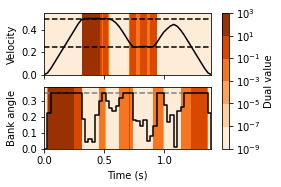

In [4]:
from copy import copy
from matplotlib import ticker, cm
def plot_vel(ax):
    ax.set(ylabel="Velocity")
    ax.axhline(y=P.v_fast, color='k', ls='--')
    ax.axhline(y=P.v_slow, color='k', ls='--')
    ax.plot(t, la.norm(v.value, axis=1),'k')#, where="post")
    #ax.step(t, la.norm(v.value, axis=1), where="post")
    palette = copy(plt.get_cmap('Oranges'))
    ax.set(ylim=[0, P.v_fast*1.1])
    return plot_duals(ax, t, g['vel_max'].dual_value, cmap='Oranges', locator=ticker.LogLocator())

def plot_angle(ax):
    ax.axhline(y=P.theta_max, color='gray', ls='--')
    bank_angle = np.arccos(a.value.dot(-P.gravity)/(la.norm(a.value,axis=1)*la.norm(P.gravity)))
    ax.step(t, bank_angle, 'k', where='post')
    ax.set(ylim=[0, P.theta_max*1.1])
    ax.set(ylabel='Bank angle',yticks=[0,.1,.2,.3])
    return plot_duals(ax, t, g['bank_angle'].dual_value, cmap='Oranges', locator=ticker.LogLocator())
    

t = np.linspace(0,P.K*tau.value,P.K) 
fig, axs = plt.subplots(nrows=2, figsize=(1.5*2.5,2.5))
cs = plot_vel(axs[0])
axs[0].set(xticklabels=[])
plot_angle(axs[1])
plt.colorbar(cs,ax=axs.ravel().tolist()).set_label('Dual value')
axs[1].set(xlabel='Time (s)')
plt.savefig('figs/vel-angle.pdf', bbox_inches='tight')

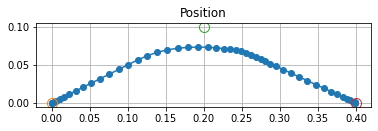

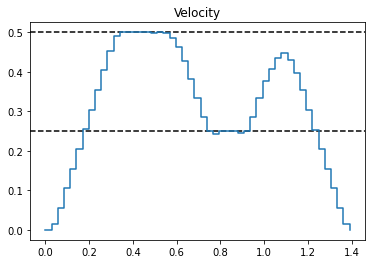

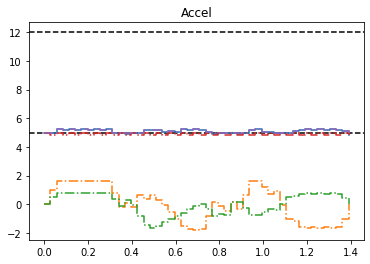

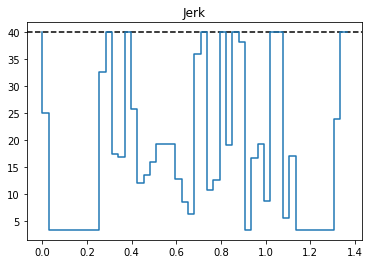

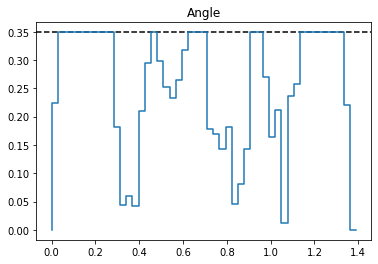

In [15]:
plt.figure()
plt.title("Position")
plt.plot(*r.value[:,:2].T, 'o-')
plt.plot(*ri.value[:2], 'o', fillstyle='none', ms=10)
plt.plot(*wp.value[:2], 'o', fillstyle='none', ms=10)
plt.plot(*rf.value[:2], 'o', fillstyle='none', ms=10)
plt.gca().set_aspect('equal')
plt.grid()
#plt.plot(r.value[:,2], 'o-')
plt.figure()
plt.title("Velocity")
plt.gca().axhline(y=P.v_fast, color='k', ls='--')
plt.gca().axhline(y=P.v_slow, color='k', ls='--')
plt.step(t, la.norm(v.value, axis=1), where="post")
# plt.plot(t, v.value, '-.')
plt.figure()
plt.title("Accel")
plt.gca().axhline(y=P.a_min, color='k', ls='--')
plt.gca().axhline(y=P.a_max, color='k', ls='--')
plt.step(t, la.norm(a.value, axis=1), where="post")
plt.step(t, a.value, '-.', where="post")
plt.step(t, s.value, '-.', where="post")
plt.figure()
plt.title("Jerk")
plt.gca().axhline(y=P.j_max, color='k', ls='--')
plt.step(t[:-1], la.norm(np.diff(a.value, axis=0), axis=1)/tau.value)
#plt.plot(t, a.value, '-.')
plt.figure()
plt.title("Angle")
plt.gca().axhline(y=P.theta_max, color='k', ls='--')
bank_angle = np.arccos(a.value.dot(-P.gravity)/(la.norm(a.value,axis=1)*la.norm(P.gravity)))
plt.step(t, bank_angle)
plt.show()

In [7]:
g["vel_initial"].dual_value

array([467.93463069, 233.78253861,  94.14632723])

In [8]:
g["vel_final"].dual_value

array([ 5.4862987 , -2.52407403, 20.87173452])

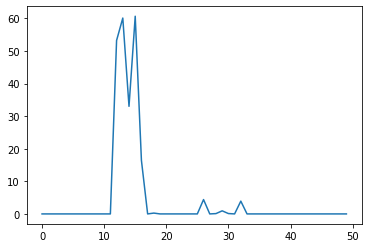

In [9]:
plt.plot(g["vel_max"].dual_value)

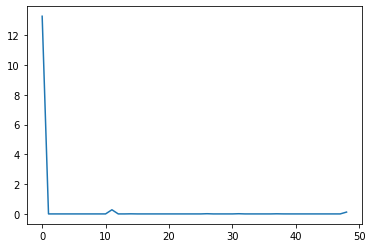

In [10]:
plt.plot(g["horizontal_jerk_max"].dual_value)

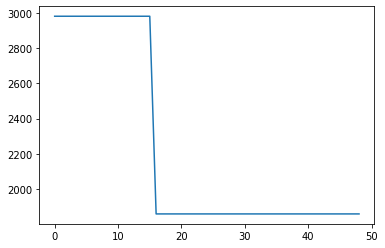

In [11]:
plt.plot(la.norm(g["dynamics_pos"].dual_value,axis=1))